In [1]:
import os, sys
sys.path.append("../../common/")
from python_tools import *
import scipy.optimize
import numba_scipy
from numba import jit, float32

python tools loaded.


In [2]:
cov_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/total_sys_pred.SBNcovar.root")
mc_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/sens_pred.SBNspec.root")
data_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/fakedata.SBNspec.root")

In [3]:
print(cov_file.keys())
print(mc_file.keys())
print(data_file.keys())

[b'full_covariance;1', b'frac_covariance;1', b'full_correlation;1', b'collapsed_covariance;1', b'collapsed_frac_covariance;1', b'collapsed_correlation;1']
[b'nu_uBooNE_1e1p_bnb;1', b'nu_uBooNE_1e1p_lee;1', b'nu_uBooNE_1mu1p_bnb;1']
[b'nu_uBooNE_1e1p_bnb;1', b'nu_uBooNE_1e1p_lee;1', b'nu_uBooNE_1mu1p_bnb;1']


In [4]:
nue_exp = mc_file["nu_uBooNE_1e1p_bnb"].numpy()[0]
numu_exp = mc_file["nu_uBooNE_1mu1p_bnb"].numpy()[0]
sig_exp = mc_file["nu_uBooNE_1e1p_lee"].numpy()[0]

data_exp = np.append(np.copy(nue_exp),numu_exp)
sig_exp = np.append(sig_exp,np.full_like(numu_exp,0))

In [5]:
m = cov_file["collapsed_covariance"]
m_cov_sys = np.copy(m._fElements.reshape(m._fNrows, m._fNcols))
m_cov_sys = np.float32(m_cov_sys)
m_cov_nue_sys = m_cov_sys[:10,:10]
m_cov_numu_sys = m_cov_sys[10:,10:]
m_cov_em_sys = m_cov_sys[:10,10:]
m_cov_me_sys = m_cov_sys[10:,:10]

m_cov_sys_inv = np.linalg.inv(m_cov_sys)
m_cov_nue_sys_inv = np.linalg.inv(m_cov_nue_sys)
m_cov_numu_sys_inv = np.linalg.inv(m_cov_numu_sys)

m_cov = np.copy(m_cov_sys)
for i in range(0,len(data_exp)):
    m_cov[i,i] += data_exp[i]
m_cov_nue = m_cov[:10,:10]
m_cov_numu = m_cov[10:,10:]
m_cov_em = m_cov[:10,10:]
m_cov_me = m_cov[10:,:10]

m_cov_inv = np.linalg.inv(m_cov)
m_cov_nue_inv = np.linalg.inv(m_cov_nue)
m_cov_numu_inv = np.linalg.inv(m_cov_numu)

In [6]:
%matplotlib notebook

<IPython.core.display.Javascript object>


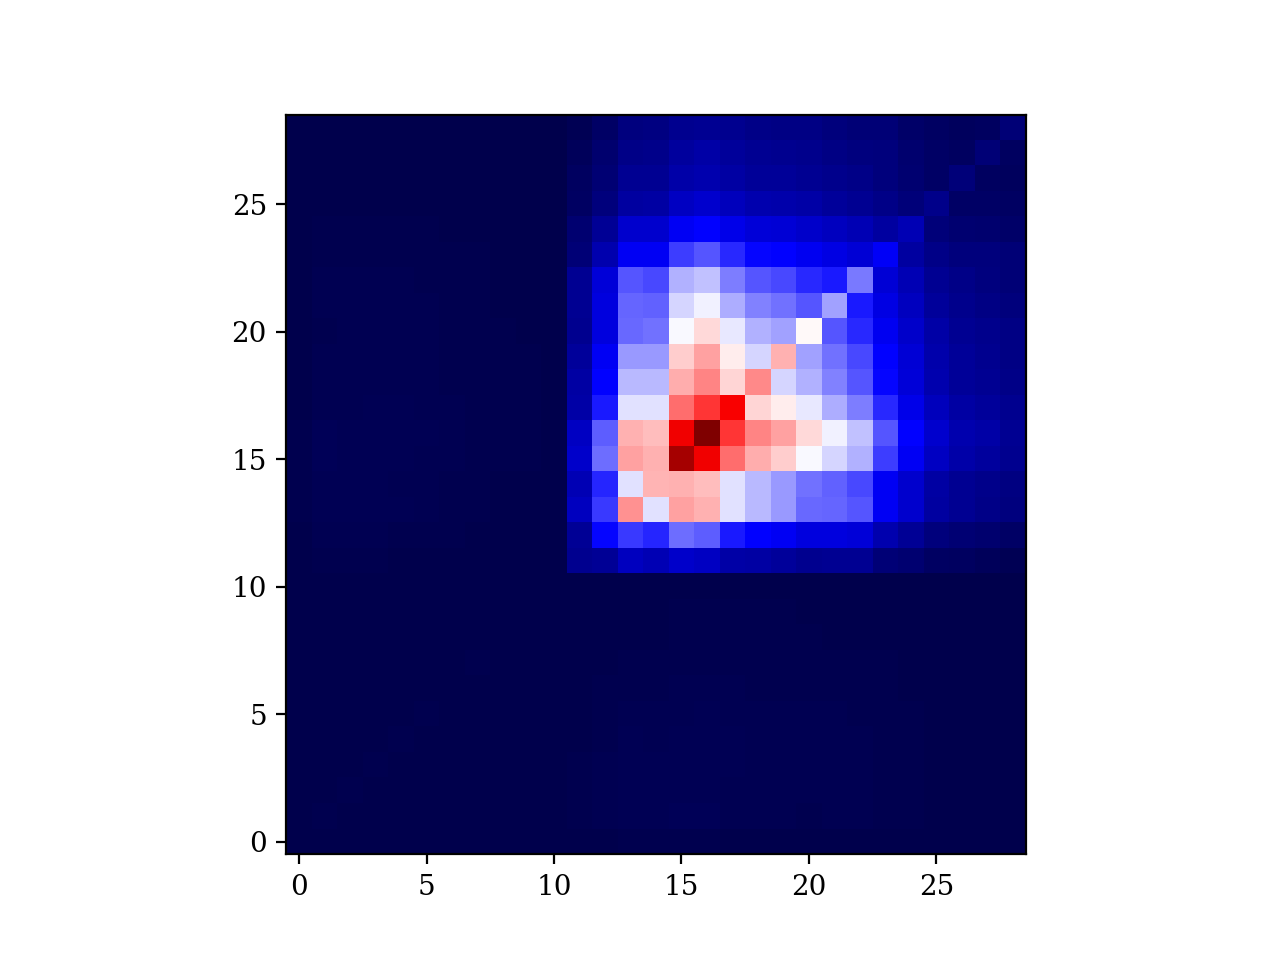

In [7]:
fig = plt.subplots()

plt.imshow(m_cov,origin={'lower','lower'})

In [8]:
nue_obs = data_file["nu_uBooNE_1e1p_bnb"].numpy()[0]
numu_obs = data_file["nu_uBooNE_1mu1p_bnb"].numpy()[0]
data_obs = np.append(np.copy(nue_obs),numu_obs)

In [9]:
def chi2(diff,m_cov_inv):
    return np.matmul(np.transpose(diff),np.matmul(m_cov_inv,diff))

def cond_exp(diff1,exp2,m_cov_11_inv,m_cov_21):
    return exp2 + np.matmul(m_cov_21,np.matmul(m_cov_11_inv,diff1))

def cond_cov(m_cov_22,m_cov_11_inv,m_cov_12,m_cov_21):
    return m_cov_22 - np.matmul(m_cov_21,np.matmul(m_cov_11_inv,m_cov_12))

def chi2_sig(x,data,sig,bkg,m_cov_sys):
    m_cov = np.copy(m_cov_sys)
    for i in range(len(bkg)):
        m_cov[i,i] += bkg[i]+x*sig[i]
    return chi2(data - (x*sig+bkg),np.linalg.inv(m_cov))

In [10]:
def get_pe(mean,m_cov_sys):
    return np.random.poisson(np.clip(np.random.multivariate_normal(mean, m_cov_sys),0,1e9))

In [11]:
def run_pes(n_pes,mu_true,bkg_exp,sig_exp,m_cov_sys):
    
    tot_exp = bkg_exp+mu_true*sig_exp
    df_pes = pd.DataFrame(index=np.arange(0,n_pes),columns=["mu_true","chi2_h0","chi2_h1","chi2_hb","chi2_diff","mu_fit","pe_data"])
    
    for i in range(int(n_pes)):
        my_pe = get_pe(tot_exp,m_cov_sys)
        chi2_h0 = chi2_sig(0.0,my_pe,sig_exp,bkg_exp,m_cov_sys)
        chi2_h1 = chi2_sig(mu_true,my_pe,sig_exp,bkg_exp,m_cov_sys)
        x0 = [np.max([0.1,mu_true])]
        res = scipy.optimize.minimize(chi2_sig,x0,
                                      args=(my_pe,
                                            sig_exp,
                                            bkg_exp,
                                            m_cov_sys),
                                      bounds=[(0,100.)])
        chi2_hb = chi2_sig(res.x[0],data=my_pe,sig=sig_exp,bkg=bkg_exp,m_cov_sys=m_cov_sys)
        df_pes.loc[i] = [mu_true,chi2_h0,chi2_h1,chi2_hb,chi2_h1-chi2_hb,res.x[0],my_pe]
        
    return df_pes


In [12]:
chi2(data_obs-data_exp,m_cov_inv)

63.92037876615094

In [13]:
chi2(numu_obs-numu_exp,np.linalg.inv(m_cov_numu))

40.485575632554095

In [14]:
chi2(nue_obs-nue_exp,np.linalg.inv(m_cov_nue))

21.089043221395904

In [15]:
nue_exp_cond = cond_exp(numu_obs-numu_exp,nue_exp,m_cov_numu_inv,m_cov_em)
m_cov_cond_sys = cond_cov(m_cov_nue_sys,m_cov_numu_sys_inv,m_cov_me_sys,m_cov_em_sys)

m_cov_cond = np.copy(m_cov_cond_sys)
for i in range(len(nue_exp_cond)):
    m_cov_cond[i,i] = m_cov_cond[i,i] + nue_exp_cond[i]

In [16]:
sig_exp_cond = sig_exp[:10] * (nue_exp_cond)/nue_exp

In [17]:
chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))

26.02156963291611

In [18]:
print(nue_exp_cond)
print(m_cov_cond)
print(m_cov_cond_sys)

[0.73839214 5.87075793 5.24409565 6.215093   6.44640893 7.10982535
 4.6103424  5.0081921  2.97406431 2.57144054]
[[0.7626439  0.01589906 0.03242362 0.02585092 0.03504227 0.03499877
  0.02096268 0.0246374  0.01582115 0.01310568]
 [0.01589778 6.4957833  0.20051485 0.32054037 0.2104578  0.22084862
  0.16582234 0.14718968 0.09032099 0.09639747]
 [0.03242159 0.20051217 5.464334   0.17992675 0.20265213 0.18775159
  0.14500612 0.13738637 0.08038225 0.08141068]
 [0.02585068 0.3205424  0.17993152 6.7247086  0.23607802 0.2111255
  0.17696235 0.1394581  0.10481262 0.10058288]
 [0.03504162 0.21045867 0.20265576 0.23607734 6.7024703  0.2247405
  0.18289885 0.16254397 0.10983548 0.10272823]
 [0.03499866 0.22085056 0.1877558  0.21112597 0.22474119 7.3499074
  0.15972963 0.16319776 0.09899607 0.09260936]
 [0.02096236 0.165823   0.14500877 0.17696235 0.18289912 0.1597296
  4.7468944  0.11552843 0.0799643  0.07705677]
 [0.02463647 0.14718784 0.13738586 0.1394554  0.16254134 0.16319528
  0.11552653 5.139

In [19]:
for i in range(20):
    my_pe = get_pe(nue_exp_cond, m_cov_cond_sys)
    print(my_pe)
    print(chi2(my_pe-nue_exp_cond,np.linalg.inv(m_cov_cond)))

[ 3  6  4  4  4 10  6  4  4  2]
10.997612945160439
[1 9 2 8 3 4 5 4 4 0]
10.258739774069161
[0 4 3 3 5 6 5 5 1 3]
5.112294340754919
[ 1  5  3  8  9 12  1  5  8  3]
17.133745711473278
[ 0  5  3 14 11  8  6  6  0  1]
18.811052516024166
[1 4 7 3 3 9 0 5 6 1]
13.44306698259157
[ 0 11  8  5  8  7  6  5  2  1]
8.475049474623649
[0 4 4 6 5 6 5 1 0 4]
8.509942580898477
[ 2  5  3 10 10  8  2  5  7  2]
14.258243214069482
[1 8 5 8 8 9 5 5 1 1]
4.405470514589288
[0 8 6 2 7 5 6 4 2 3]
5.955800869766716
[1 7 1 8 5 2 1 5 3 4]
11.391974447313748
[0 3 9 3 8 6 3 5 4 2]
7.792081243821009
[ 0  7  1 11  7  6  3  5  2  2]
8.976939643507725
[2 5 7 2 8 6 6 7 1 4]
9.328722951909587
[ 0  2  2  3 10  5  5  3  0  1]
12.954768163634718
[0 5 5 5 6 6 4 9 1 3]
5.867418999990109
[1 6 9 4 3 4 5 3 3 2]
7.505860880580273
[ 0  5  1  7  7  8  0 10  0  1]
17.632516910895273
[0 7 1 4 6 2 4 8 1 4]
12.347044095876019


/Library/Python/3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


In [20]:
run_pes(1,1.0,nue_exp_cond,sig_exp_cond,m_cov_cond_sys)

/Library/Python/3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


,mu_true,chi2_h0,chi2_h1,chi2_hb,chi2_diff,mu_fit,pe_data
0,1,52.4127,21.5232,20.5996,0.923602,1.20997,"[3, 20, 5, 3, 9, 10, 9, 6, 8, 4]"


In [21]:
true_vals = np.arange(0,5.05,0.05)
n_pes = 25e3

In [22]:
df_pes_cond = pd.DataFrame()
for x in true_vals:
    print("\tRunning x=%f"%x)
    df_pes_cond = df_pes_cond.append(run_pes(n_pes,x,nue_exp_cond,sig_exp_cond[:10],m_cov_cond_sys))

	Running x=0.000000


/Library/Python/3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


	Running x=0.050000
	Running x=0.100000
	Running x=0.150000
	Running x=0.200000
	Running x=0.250000
	Running x=0.300000
	Running x=0.350000
	Running x=0.400000
	Running x=0.450000
	Running x=0.500000
	Running x=0.550000
	Running x=0.600000
	Running x=0.650000
	Running x=0.700000
	Running x=0.750000
	Running x=0.800000
	Running x=0.850000
	Running x=0.900000
	Running x=0.950000
	Running x=1.000000
	Running x=1.050000
	Running x=1.100000
	Running x=1.150000
	Running x=1.200000
	Running x=1.250000
	Running x=1.300000
	Running x=1.350000
	Running x=1.400000
	Running x=1.450000
	Running x=1.500000
	Running x=1.550000
	Running x=1.600000
	Running x=1.650000
	Running x=1.700000
	Running x=1.750000
	Running x=1.800000
	Running x=1.850000
	Running x=1.900000
	Running x=1.950000
	Running x=2.000000
	Running x=2.050000
	Running x=2.100000
	Running x=2.150000
	Running x=2.200000
	Running x=2.250000
	Running x=2.300000
	Running x=2.350000
	Running x=2.400000
	Running x=2.450000
	Running x=2.500000


In [ ]:
df_pes_tot = pd.DataFrame()
for x in true_vals:
    print("\tRunning x=%f"%x)
    df_pes_tot = df_pes_tot.append(run_pes(n_pes,x,data_exp,sig_exp,m_cov_sys))

	Running x=0.000000
	Running x=0.050000
	Running x=0.100000
	Running x=0.150000
	Running x=0.200000
	Running x=0.250000
	Running x=0.300000
	Running x=0.350000
	Running x=0.400000


In [ ]:
df_pes_cond

In [ ]:
df_pes_tot

In [23]:
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

In [24]:
def get_critical_vals(true_vals,quantiles,df_pes):

    critical_vals = np.empty((len(quantiles),len(true_vals)))

    for ix in range(len(true_vals)):
        x = true_vals[ix]
        qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.0001,x+0.0001))
        df_pes['mu_true'] = df_pes['mu_true'].astype(float)
        cvals = np.quantile(df_pes.query(qstring)["chi2_diff"],quantiles)
        
        for iv in range(len(cvals)):
            critical_vals[iv,ix] = cvals[iv]

    return critical_vals

In [ ]:
def get_fc_interval(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    return (np.amin(vals),np.amax(vals),vals)
def get_fc_interval_min(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    if len(vals)==0:
        return -1
    return np.amin(vals)
def get_fc_interval_max(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    if len(vals)==0:
        return 9999
    return np.amax(vals)

In [ ]:
def chi2_diff(data,x_vals,sig,bkg,m_cov_inv):
    x0 = [0.1]
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(data,
                                        sig,
                                        bkg,
                                        m_cov_inv),
                                        bounds=[(0,100.)])
    chi2_hb_obs = chi2_sig(res.x[0],data=data,sig=sig,bkg=bkg,m_cov_inv=m_cov_inv)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = chi2_sig(x_vals[ix],data=data,sig=sig,bkg=bkg,m_cov_inv=m_cov_inv)-chi2_hb_obs
    return chi2_diff


In [53]:
@jit
def chi2_diff_numba(data,x_vals,sig,bkg,m_cov_sys):
    x0 = [0.1]
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(data,
                                        sig,
                                        bkg,
                                        m_cov_sys),
                                        bounds=[(0,100.)])
    chi2_hb_obs = chi2_sig(res.x[0],data=data,sig=sig,bkg=bkg,m_cov_sys=m_cov_sys)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = chi2_sig(x_vals[ix],data=data,sig=sig,bkg=bkg,m_cov_sys=m_cov_sys)-chi2_hb_obs
    return chi2_diff

@jit
def get_fc_interval_numba(chi2_diff,true_vals,critical_vals):
    intervals = []
    for ic in range(len(critical_vals)):
        vals = np.where(chi2_diff<critical_vals[ic],true_vals,np.nan)
        vals = vals[~np.isnan(vals)]
        if len(vals)==0:
            intervals.append((-1,9999))
        else:
            intervals.append((np.amin(vals),np.amax(vals)))
    return intervals

@jit
def calc_fc_interval_numba(data,x_vals,sig,bkg,m_cov_sys,critical_vals):
    return get_fc_interval_numba(chi2_diff_numba(data,x_vals,sig,bkg,m_cov_sys),x_vals,critical_vals)

In [26]:
critical_vals_cond = get_critical_vals(true_vals,[sigma1,sigma2,sigma3],df_pes_cond)

In [ ]:
calc_fc_interval_numba(df_pes_tot.iloc[0]["pe_data"],true_vals,sig_exp,data_exp,m_cov_inv,critical_vals_tot)

In [ ]:
df_tmp = df_pes_tot.iloc[:10].copy()
#df_tmp["intvl_min_s1"], df_tmp["intvl_min_s2"] = zip(*df_tmp["pe_data"].apply(lambda pe: calc_fc_interval_numba(pe,true_vals,sig_exp,data_exp,m_cov_inv,critical_vals_tot[0])))
df_tmp["intervals"] = df_tmp["pe_data"].apply(lambda pe: calc_fc_interval_numba(pe,true_vals,sig_exp,data_exp,m_cov_inv,critical_vals_tot))


In [ ]:
df_tmp

In [ ]:
critical_vals_tot = get_critical_vals(true_vals,[sigma1,sigma2,sigma3],df_pes_tot)
critical_vals_cond = get_critical_vals(true_vals,[sigma1,sigma2,sigma3],df_pes_cond)

In [ ]:
def add_fc_intervals(df_pes,x_vals,critical_vals,sig,bkg,m_cov_inv):
    df_pes["fc_interval_min_s1"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[0]))
    df_pes["fc_interval_max_s1"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[0]))
    df_pes["fc_interval_min_s2"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[1]))
    df_pes["fc_interval_max_s2"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[1]))
    #df_pes["fc_interval_min_s3"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[2]))
    #df_pes["fc_interval_max_s3"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[2]))
    
    df_pes["true_contained_s1"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s1"],
                                                 df_pes["mu_true"]<=df_pes["fc_interval_max_s1"])
    df_pes["true_contained_s2"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s2"],
                                                 df_pes["mu_true"]<=df_pes["fc_interval_max_s2"])
    #df_pes["true_contained_s3"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s3"],
    #                                             df_pes["mu_true"]<=df_pes["fc_interval_max_s3"])
    return df_pes

In [ ]:
diff_obs = chi2_diff(df_pes_tot.iloc[1]["pe_data"],true_vals,sig_exp,data_exp,m_cov_inv)

In [ ]:
for cval in critical_vals_tot:
    print(get_fc_interval(diff_obs,true_vals,cval))

In [ ]:
df_tmp = df_pes_tot.iloc[:10].copy()

In [ ]:
df_pes_tot = add_fc_intervals(df_pes_tot,true_vals,critical_vals_tot,sig_exp,data_exp,m_cov_inv)

In [ ]:
df_pes_cond["intervals"] = df_pes_cond["pe_data"].apply(lambda pe: calc_fc_interval_numba(pe,true_vals,sig_exp[:10],nue_exp_cond,np.linalg.inv(m_cov_cond),critical_vals_cond))

In [27]:
df_pes_cond

,mu_true,chi2_h0,chi2_h1,chi2_hb,chi2_diff,mu_fit,pe_data
0.0,0.0,3.93082,3.93082,3.93082,0,0,"[1, 4, 4, 3, 5, 5, 6, 5, 2, 2]"
1.0,0.0,6.66413,6.66413,6.66413,0,0,"[0, 4, 7, 5, 9, 7, 4, 9, 4, 3]"
2.0,0.0,5.90941,5.90941,5.83369,0.0757228,0.0713171,"[1, 5, 7, 5, 9, 8, 5, 4, 1, 5]"
3.0,0.0,21.5328,21.5328,17.343,4.18977,0.370016,"[1, 12, 0, 8, 10, 4, 7, 1, 1, 4]"
4.0,0.0,5.8419,5.8419,5.8419,0,0,"[1, 4, 6, 6, 5, 4, 4, 1, 4, 2]"
...,...,...,...,...,...,...,...
24995.0,5.0,516.918,6.80488,6.64796,0.156918,5.25111,"[14, 47, 16, 15, 11, 6, 4, 5, 3, 0]"
24996.0,5.0,413.84,3.57239,3.5577,0.0146805,5.04098,"[13, 38, 23, 14, 15, 11, 7, 6, 2, 4]"
24997.0,5.0,717.56,10.2782,3.83701,6.44122,6.61539,"[13, 61, 24, 14, 10, 11, 5, 6, 2, 2]"
24998.0,5.0,530.269,13.0817,7.43931,5.64242,6.47558,"[11, 44, 34, 24, 12, 12, 5, 5, 4, 3]"


In [49]:
print(np.shape(sig_exp_cond[:10]))
print(np.shape(m_cov_cond_sys))
print(np.shape(nue_exp_cond))

(10,)
(10, 10)
(10,)


In [55]:
calc_fc_interval_numba(nue_obs,true_vals,sig_exp_cond[:10],nue_exp_cond,m_cov_cond_sys,critical_vals_cond)

[(0.5, 1.1), (0.2, 1.6500000000000001), (0.0, 2.35)]

In [ ]:
calc_fc_interval_numba(data_obs,true_vals,sig_exp,data_exp,np.linalg.inv(m_cov),critical_vals_tot)

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(data_obs,
                                    sig_exp,
                                    data_exp,
                                    m_cov_inv),
                                    bounds=[(0,100.)])
print(res)

In [29]:
x0 = [0.1]
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(nue_obs,
                                    sig_exp_cond,
                                    nue_exp_cond,
                                    m_cov_cond_sys),
                                    bounds=[(0,100.)])
print(res)

      fun: 13.29831169260314
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.75538091])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 122
      nit: 2
   status: 2
  success: False
        x: array([0.72935284])


<IPython.core.display.Javascript object>


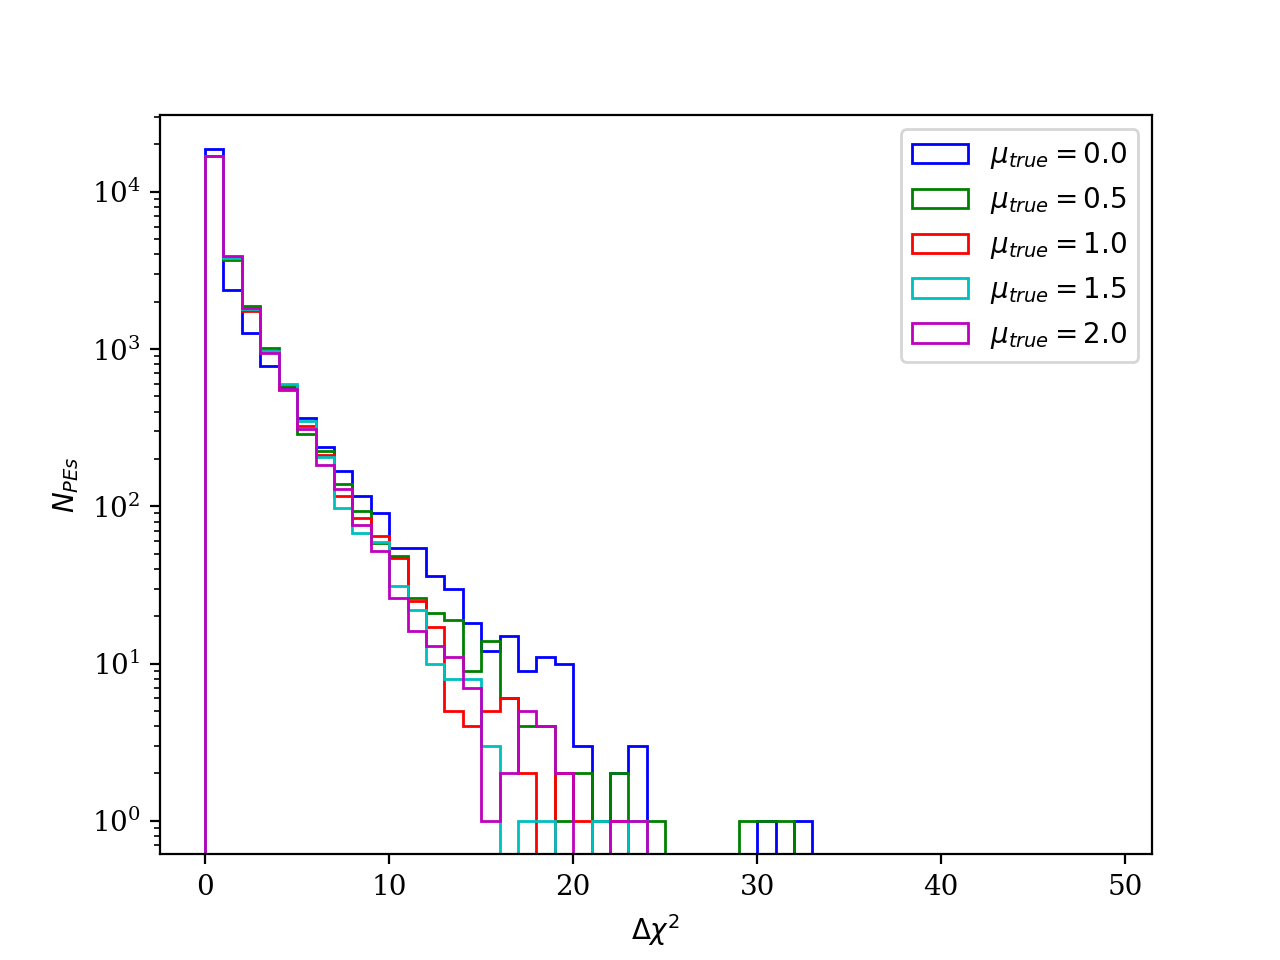

In [31]:
fig,ax = plt.subplots()

bins=np.arange(0,50,1)

ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax.hist(df_pes_cond.query("abs(mu_true-0.5)<0.001")["chi2_diff"],bins=bins,label="$\mu_{true}=0.5$",histtype="step",log=True)
ax.hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_diff"],bins=bins,label="$\mu_{true}=1.0$",histtype="step",log=True)
ax.hist(df_pes_cond.query("abs(mu_true-1.5)<0.001")["chi2_diff"],bins=bins,label="$\mu_{true}=1.5$",histtype="step",log=True)
ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_diff"],bins=bins,label="$\mu_{true}=2.0$",histtype="step",log=True)

plt.legend()
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig(tmp_plot())

<IPython.core.display.Javascript object>


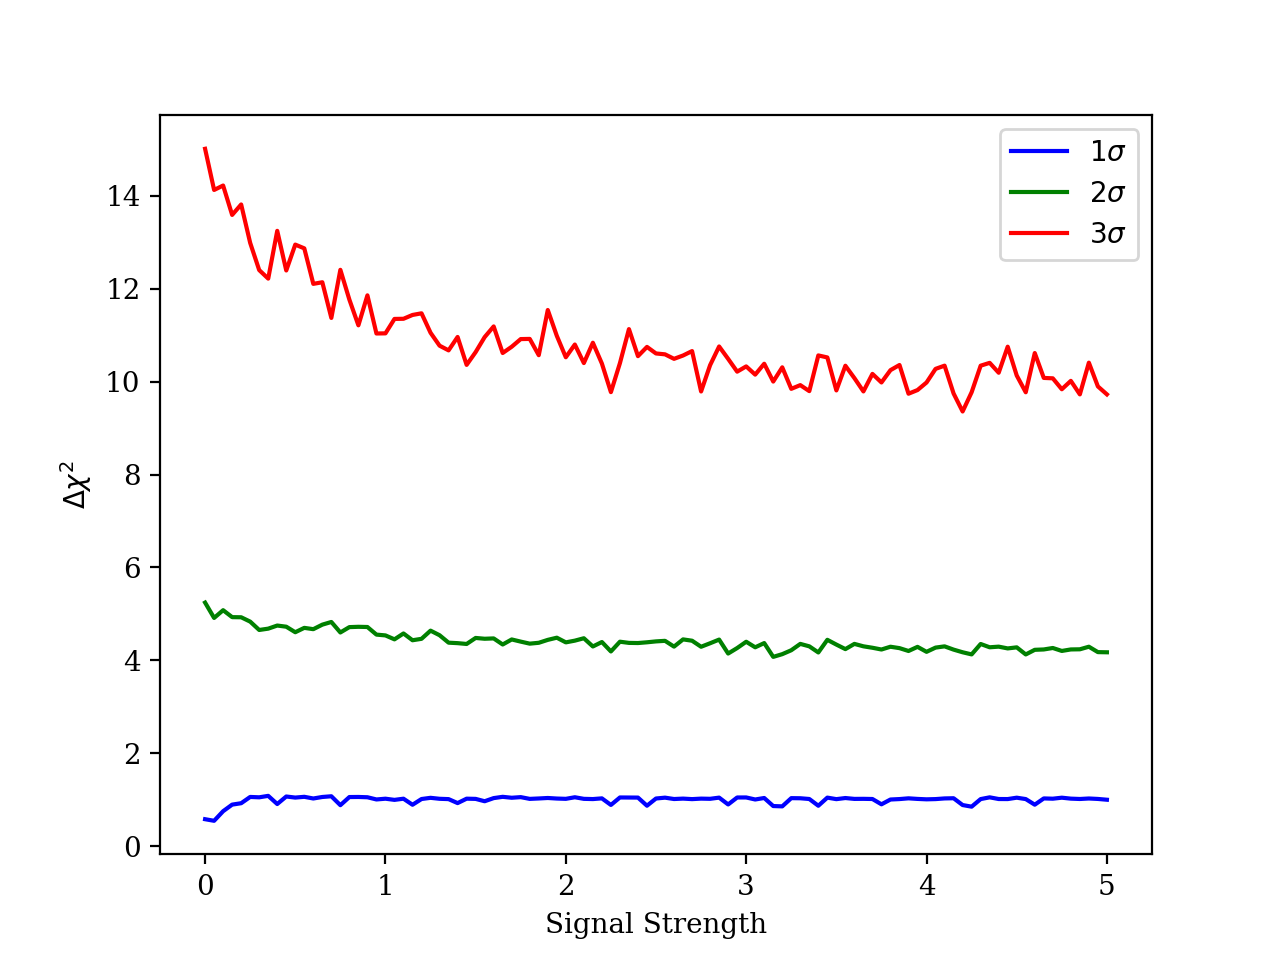

In [32]:
fig,ax = plt.subplots()

#bins=np.arange(0,50,1)

ax.plot(true_vals,critical_vals_cond[0],label="$1\sigma$")
ax.plot(true_vals,critical_vals_cond[1],label="$2\sigma$")
ax.plot(true_vals,critical_vals_cond[2],label="$3\sigma$")

plt.legend()
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("Signal Strength")

plt.show()
plt.savefig(tmp_plot())

In [ ]:
critical_vals_cond[0][0]

In [ ]:
critical_vals_cond[0][20]

<IPython.core.display.Javascript object>


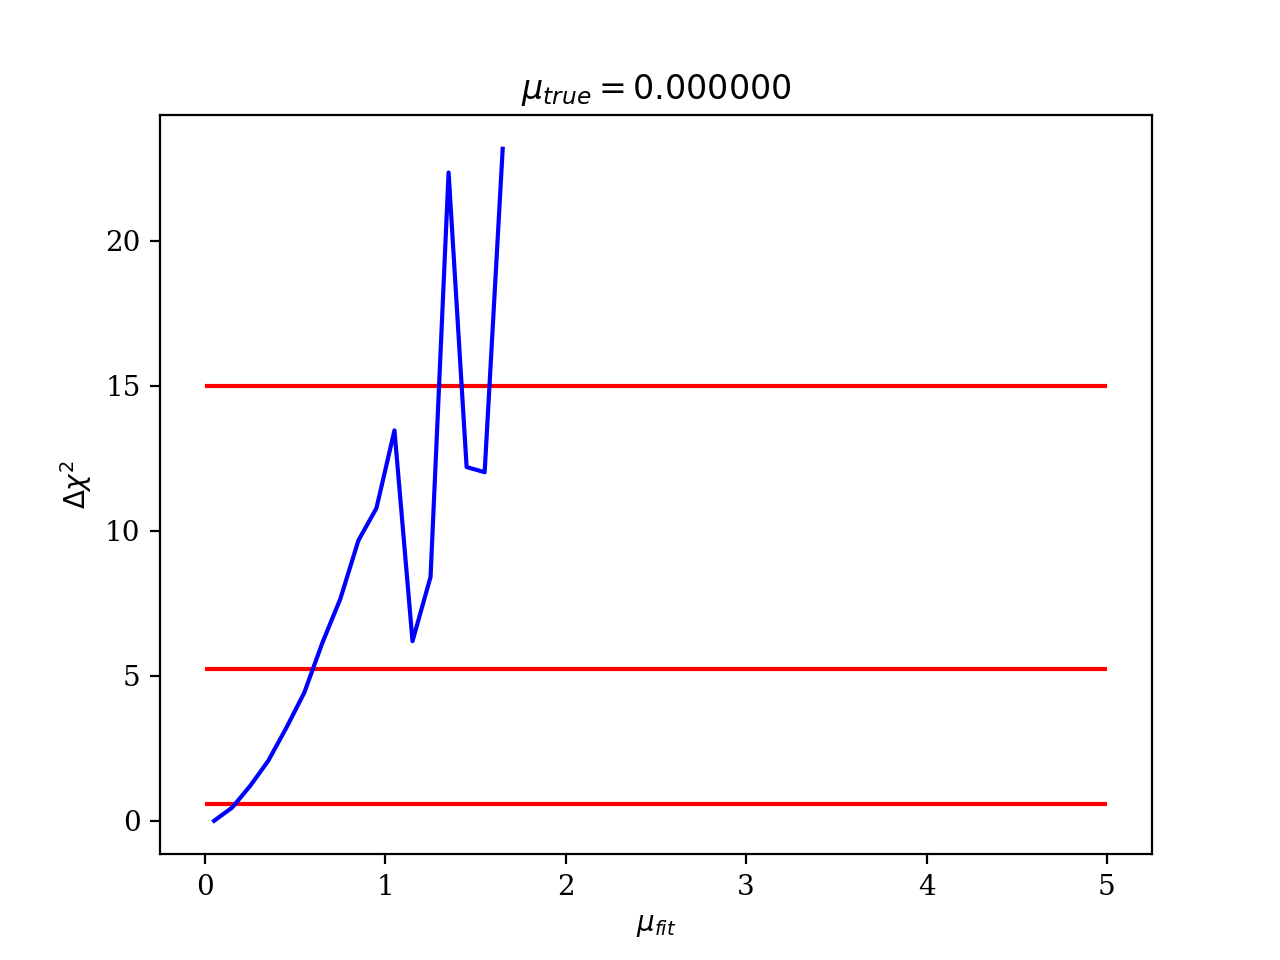

In [68]:
itrue = 0
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

df_pes_cond["mu_fit"] = df_pes_cond["mu_fit"].astype("float")
df_pes_cond["chi2_diff"] = df_pes_cond["chi2_diff"].astype("float")
res = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff",func="median")


fig,ax = plt.subplots()


ax.plot(res["x"],res["median"])
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='r',label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='r',label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='r',label="")


#plt.legend()
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
#plt.savefig("/Users/wketchum/Downloads/temp.pdf")


In [ ]:
itrue = 0
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_cond = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff")
res_tot = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff")


fig,ax = plt.subplots()


ax.plot(res_cond["x"],res_cond["y"],color='blue',label="Using Conditional Covariance Matrix")
ax.plot(res_tot["x"],res_tot["y"],color='black',label="Using Full Covariance Matrix")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[0][itrue],color='k',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[1][itrue],color='k',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[2][itrue],color='k',linestyle="--")


plt.legend(loc=2)
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
plt.savefig("/Users/wketchum/Plots/temp_%d.pdf"%np.round(time.time()))

In [ ]:
def make_profile_bins(df,lowbin,hibin,nbins,xarg,yarg,option='sem',func='mean'):
    xbins = np.linspace(lowbin,hibin,nbins+1)
    diff = (xbins[1]-xbins[0])*0.00001
    xbins[-1] = xbins[-1]+diff
    result = (df[[xarg,yarg]].groupby(np.digitize(df[xarg],bins=xbins,right=False)))[yarg].agg([func,option])
    result = result.reindex(range(1,len(xbins),1))
    xbins[-1] = xbins[-1]-diff
    result["x"] = 0.5*(xbins[:-1]+xbins[1:])
    result["xerr"] = 0.5*(xbins[1]-xbins[0])
    result.rename(columns={func: 'y', option: 'yerr'}, inplace=True)
    return result

In [ ]:
itrue = 40
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_cond = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")
res_tot = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")

print(res_tot)

In [ ]:
itrue = 20
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_mean = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")
res_median = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="mean")


fig,ax = plt.subplots()


ax.plot(res_mean["x"],res_mean["y"],color='k')
ax.plot(res_median["x"],res_median["y"],color='k',linestyle="-.")
#ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='blue',linestyle="--",label="")
#ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='blue',linestyle="--",label="")
#ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='blue',linestyle="--",label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[0][itrue],color='k',linestyle="--",label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[1][itrue],color='k',linestyle="--",label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[2][itrue],color='k',linestyle="--",label="")


#plt.legend()
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
res_median

In [ ]:
res_mean

In [ ]:
import time

In [ ]:
fig,ax = plt.subplots()
bins=np.arange(0,5,0.01)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.0)<0.05")["chi2_diff"],
        bins=bins,label="$0.95<\mu_{fit}<1.05$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.1)<0.05")["chi2_diff"],
        bins=bins,label="$1.05<\mu_{fit}<1.15$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.2)<0.05")["chi2_diff"],
        bins=bins,label="$1.15<\mu_{fit}<1.25$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.3)<0.05")["chi2_diff"],
        bins=bins,label="$1.25<\mu_{fit}<1.35$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.4)<0.05")["chi2_diff"],
        bins=bins,label="$1.35<\mu_{fit}<1.45$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.5)<0.05")["chi2_diff"],
        bins=bins,label="$1.45<\mu_{fit}<1.55$",histtype="step",log=True)
        

ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.legend()
plt.title("$\mu_{true}=1.0$")
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp_%d.pdf"%np.round(time.time()))

In [ ]:
print(np.count_nonzero(df_pes_tot["true_contained_s1"])/len(df_pes_tot))
print(np.count_nonzero(df_pes_tot["true_contained_s2"])/len(df_pes_tot))
for x in true_vals:
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.0001,x+0.0001))
    print("Coverage for x=%f: 1sigma=%f, 2sigma=%f"%(x,
                                                     np.count_nonzero(df_pes_tot.query(qstring)["true_contained_s1"])/len(df_pes_tot.query(qstring)),
                                                     np.count_nonzero(df_pes_tot.query(qstring)["true_contained_s2"])/len(df_pes_tot.query(qstring))))

In [ ]:
np.logical_and(df_tmp["mu_true"]>=df_tmp["fc_interval_min_s1"],df_tmp["mu_true"]<=df_tmp["fc_interval_max_s1"])

In [ ]:
df_tmp

In [ ]:
print chi2_diff(nue_obs,)

res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(nue_obs,
                                        sig_exp,
                                        nue_exp_cond,
                                        np.linalg.inv(m_cov_cond)),
                                        bounds=[(0,100.)])

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,100,0.5)

ax.hist(df_pes.query("mu_true==0.0")["chi2_diff"],bins=bins,color='r',label="'H0'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==1.0")["chi2_diff"],bins=bins,color='b',label="'LEE x1'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==2.0")["chi2_diff"],bins=bins,color='g',label="'LEE x2'",histtype="step",log=True)

plt.legend()
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,10,0.1)

ax.hist(df_pes.query("mu_true==0.0")["mu_fit"],bins=bins,color='r',label="'H0'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==1.0")["mu_fit"],bins=bins,color='b',label="'LEE x1'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==2.0")["mu_fit"],bins=bins,color='g',label="'LEE x2'",histtype="step",log=True)

plt.legend()
ax.set_xlabel("Best Fit Signal Strength")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
df_pes.query("mu_true==0")["chi2_diff"]

In [ ]:
for x in np.arange(0,5.0,0.1):
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.01,x+0.01))
    df_pes['mu_true'] = df_pes['mu_true'].astype(float)
    print("mu_true=%f"%x,np.quantile(df_pes.query(qstring)["chi2_diff"],[sigma1,sigma2,sigma3]))

In [ ]:
for x in np.arange(0,5.0,0.1):
    chi2_h0_obs = chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(nue_obs,
                                        sig_exp,
                                        nue_exp_cond,
                                        np.linalg.inv(m_cov_cond)),
                                        bounds=[(0,100.)])
    chi2_h1_obs = chi2_sig(x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
    chi2_hb_obs = chi2_sig(res.x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
    print("x=%f, chi2_h0_obs=%f, chi2_h1_obs=%f, chi2_hb_obs=%f, diff=%f (best fit=%f)"%(x,chi2_h0_obs,chi2_h1_obs,chi2_hb_obs,chi2_h1_obs-chi2_hb_obs,res.x[0]))

In [ ]:
hist_mu_00,bins = np.histogram(df_pes.query("mu_true==0")["mu_fit"].astype(float),bins=np.arange(0,10,0.1))

In [ ]:
hist_mu_00

In [ ]:
bins

In [ ]:
np.argmax(hist_mu_00[1:])+1

In [ ]:
def interval(df,level,prec=0.01):
    n_pes = len(df)
    hist_mu,bins = np.histogram(df,bins=np.arange(0,500,prec))
    init_max = np.argmax(hist_mu[1:])+1
    ilo = init_max
    ihi = init_max
    integral = hist_mu[init_max]
    
    while(integral < level*n_pes):
        if ilo==0:
            ihi += 1
            integral += hist_mu[ihi]
        elif(ihi==len(bins)-1):
            ilo -= 1
            integral += hist_mu[ilo]
        elif hist_mu[ilo-1]>hist_mu[ihi+1]:
            ilo -= 1
            integral += hist_mu[ilo]
        elif hist_mu[ilo-1]<=hist_mu[ihi+1]:
            ihi += 1
            integral += hist_mu[ihi]
    return bins[ilo], bins[ihi]+0.1, (integral/n_pes)

In [ ]:
interval(df_pes.query("mu_true==0.0")["mu_fit"],level=0.67)

In [ ]:
for x in np.arange(0,5.0,0.1):
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.01,x+0.01))
    df_pes['mu_true'] = df_pes['mu_true'].astype(float)
    lo, hi, coverage = interval(df_pes.query(qstring)["mu_fit"],level=0.67)
    print("For true signal strength %f: %f < mu_fit < %f (coverage=%f)"%(x,lo,hi,coverage))

In [ ]:
chi2_h0_obs = chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(nue_obs,
                                    sig_exp,
                                    nue_exp_cond,
                                    np.linalg.inv(m_cov_cond)),
                                    bounds=[(0,100.)])
chi2_h1_obs = chi2_sig(res.x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
print("chi2_h0_obs=%f, chi2_h1_obs=%f, diff=%f (best fit=%f)"%(chi2_h0_obs,chi2_h1_obs,chi2_h0_obs-chi2_h1_obs,res.x[0]))

In [ ]:
len(df_pes.query("mu_true==0 and mu_fit>0.683232"))/len(df_pes.query("mu_true==0"))

In [ ]:
def confidence_bands(x_vals,df_pes,level,var="mu_fit",prec=0.01,verbose=False):
    x_lo = []
    x_hi = []
    for x in x_vals:
        qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.001,x+0.001))
        df_pes['mu_true'] = df_pes['mu_true'].astype(float)
        lo, hi, coverage = interval(df_pes.query(qstring)[var],level,prec)
        x_lo.append(lo)
        x_hi.append(hi)
        if verbose:
            print("For true signal strength %f: %f < mu_fit < %f (coverage=%f)"%(x,lo,hi,coverage))
    return x_lo, x_hi

In [ ]:
x_vals = np.arange(0,5.,0.1)
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

x_lo1, x_hi1 = confidence_bands(x_vals,df_pes,level=sigma1,prec=0.05)
x_lo2, x_hi2 = confidence_bands(x_vals,df_pes,level=sigma2,prec=0.05)
x_lo3, x_hi3 = confidence_bands(x_vals,df_pes,level=sigma3,prec=0.05)

In [ ]:
len(df_pes.query("mu_true==0 and chi2_diff>4.686515"))/len(df_pes.query("mu_true==0"))

In [ ]:
fig,ax = plt.subplots()

ax.plot(x_lo1,x_vals,color='b',label="$1\sigma$")
ax.plot(x_hi1,x_vals,color='b')

ax.plot(x_lo2,x_vals,color='b',linestyle="--",label="$2\sigma$")
ax.plot(x_hi2,x_vals,color='b',linestyle="--")

ax.plot(x_lo3,x_vals,color='b',linestyle="dotted",label="$3\sigma$")
ax.plot(x_hi3,x_vals,color='b',linestyle="dotted")

ax.vlines(x=res.x[0],ymin=x_vals[0],ymax=x_vals[-1],color='r',label="Observed, Fake Dataset2")

plt.legend(loc=4)
ax.set_xlabel("Fit Signal Strength")
ax.set_ylabel("True Signal Strength")

plt.grid(True)
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
x_vals = np.arange(0,5.,0.1)
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

x_lo1, x_hi1 = confidence_bands(x_vals,df_pes,level=sigma1,var="chi2_diff",prec=1.)
x_lo2, x_hi2 = confidence_bands(x_vals,df_pes,level=sigma2,var="chi2_diff",prec=1.)
#x_lo3, x_hi3 = confidence_bands(x_vals,df_pes,level=sigma3,var="chi2_diff",prec=1.)

In [ ]:
fig,ax = plt.subplots()

ax.plot(x_lo1,x_vals,color='b',label="$1\sigma$")
ax.plot(x_hi1,x_vals,color='b')

ax.plot(x_lo2,x_vals,color='b',linestyle="--",label="$2\sigma$")
ax.plot(x_hi2,x_vals,color='b',linestyle="--")

#ax.plot(x_lo3,x_vals,color='b',linestyle="dotted",label="$3\sigma$")
#ax.plot(x_hi3,x_vals,color='b',linestyle="dotted")

ax.vlines(x=(chi2_h0_obs-chi2_h1_obs),ymin=x_vals[0],ymax=x_vals[-1],color='r',label="Observed, Fake Dataset2")

plt.legend(loc=4)
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("True Signal Strength")

ax.set_xlim(left=0.,right=100.)
plt.grid(True)
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")